# K-Nearest Neighbor Lab





In [460]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt

## 1. Implement the k-nearest neighbor (KNN) algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors
- Implement both the regular (classifcation) version and the regression version
- Include optional distance weighting for both algorithms

In [461]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, n_neighbors=5, columntype=[], weight_type='inverse_distance'): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.n_neighbors = n_neighbors
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type

    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.data = data
        self.labels = labels
        if type(labels[0][0]) == np.float64:
            self.regression = True
        else:
            self.regression = False

        return self
    
    def predict(self, data):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        # Loop through data and predict the label for each point
        predictions = []
        for i in range(len(data)):
            # Get the distances between the current point and all other points
            distances = self.calculate_distance_single_point(self.data, data[i])
            # Get the k nearest neighbors
            if self.weight_type == 'inverse_distance':
                k_indices = np.argsort(-distances)[:self.n_neighbors]
                k_labels = self.labels[k_indices]
                k_values = [distances[j] for j in k_indices]
                if self.regression:
                    prediction = np.average(k_labels[:,0], weights=k_values)
                else:
                    pred_map = {}
                    for l in k_labels:
                        pred_map[l[0]] = 0
                    for l, v in zip(k_labels, k_values):
                        pred_map[l[0]] += v
                    prediction = max(pred_map, key=pred_map.get)
            else:
                k_indices = np.argsort(distances)[:self.n_neighbors]

                # Get the labels of the k nearest neighbors
                k_labels = self.labels[k_indices]

                if self.regression:
                    prediction = np.mean(k_labels)
                else:
                    # Get the most common label
                    labels, counts = np.unique(k_labels, return_counts=True)
                    prediction = labels[np.argmax(counts)]

            predictions.append(prediction)

        return np.array(predictions)

    #Returns the Mean score given input data and labels
    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        if self.regression:
            # mean squared error
            return np.mean((self.predict(X) - y.squeeze())**2)
        else:
            pred = self.predict(X)
            correct = 0
            for y_hat, y_truth in zip(pred, y):
                if y_hat == y_truth:
                    correct += 1
            score = correct / len(y)

        return score

    def calculate_distance_single_point(self, X, y):
        """ Calculate the distance between a target point and all other points.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array with a single target
        Returns:
            distance : float
                Euclidean distance between every two points
        """
        X = np.nan_to_num(X, nan=2)
        
        distances = np.sqrt(np.sum((X-y)**2, axis=1))

        if self.weight_type == 'inverse_distance':
            return (1 / (distances+0.000000000001)**2) * distances
        else:
            return distances
    

## Debug and Evaluation

Debug and Evaluate your model using the parameters below:
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance
---

### 1.1 (20%) Debug using this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff)

Expected Results:
- Not using inverse weighted distancing = roughly [68.29%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_no_inv_predictions.txt)
- Using inverse weighted distancing = roughly [74.39%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_inv_predictions.txt)

In [48]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff > glass_train.arff
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff > glass_test.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12431  100 12431    0     0  20739      0 --:--:-- --:--:-- --:--:-- 20892
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5431  100  5431    0     0  30571      0 --:--:-- --:--:-- --:--:-- 31212


In [462]:
from scipy.io import arff

In [463]:
# Load train glass data
glass_training_data, meta = arff.loadarff("glass_train.arff")
glass_training_data = np.array(glass_training_data.tolist())
num_features = len(glass_training_data[0]) - 1
X_train = glass_training_data[:,:num_features]
X_train = X_train.astype(np.float64)
y_train = np.expand_dims(glass_training_data[:,num_features], axis=1)
y_train = y_train.astype(str)

# Load test glass data
glass_test_data, meta = arff.loadarff("glass_test.arff")
glass_test_data = np.array(glass_test_data.tolist())
num_features = len(glass_test_data[0]) - 1
X_test = glass_test_data[:,:num_features]
X_test = X_test.astype(np.float64)
y_test = np.expand_dims(glass_test_data[:,num_features], axis=1)
y_test = y_test.astype(str)

# Train on training set
model_no_d_weight = KNNClassifier(n_neighbors=3, weight_type="normal")
model_no_d_weight.fit(X_train, y_train)

model_d_weight = KNNClassifier(n_neighbors=3)
model_d_weight.fit(X_train, y_train)

# Predict on test set
score_no_d_weight = model_no_d_weight.score(X_test, y_test)
print(f"No Distance Weight Score: {score_no_d_weight}")

score_d_weight = model_d_weight.score(X_test, y_test)
print(f"Distance Weight Score: {score_d_weight}")

No Distance Weight Score: 0.6829268292682927
Distance Weight Score: 0.7439024390243902


### 1.2 (20%) Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff) and have your code print the accuracy.

In [229]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff > diabetes_train.arff
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff > diabetes_test.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37419  100 37419    0     0   177k      0 --:--:-- --:--:-- --:--:--     0:-- --:--:--  181k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73698  100 73698    0     0   339k      0 --:--:-- --:--:-- --:--:--  346k


In [464]:
# Load train diabetes data
diabetes_training_data, meta = arff.loadarff("diabetes_train.arff")
diabetes_training_data = np.array(diabetes_training_data.tolist())
num_features = len(diabetes_training_data[0]) - 1
X_train = diabetes_training_data[:,:num_features]
X_train = X_train.astype(np.float64)
y_train = np.expand_dims(diabetes_training_data[:,num_features], axis=1)
y_train = y_train.astype(str)

# Load test diabetes data
diabetes_test_data, meta = arff.loadarff("diabetes_test.arff")
diabetes_test_data = np.array(diabetes_test_data.tolist())
num_features = len(diabetes_test_data[0]) - 1
X_test = diabetes_test_data[:,:num_features]
X_test = X_test.astype(np.float64)
y_test = np.expand_dims(diabetes_test_data[:,num_features], axis=1)
y_test = y_test.astype(str)

# Train on training set
model_no_d_weight = KNNClassifier(n_neighbors=3, weight_type="normal")
model_no_d_weight.fit(X_train, y_train)

model_d_weight = KNNClassifier(n_neighbors=3)
model_d_weight.fit(X_train, y_train)

# Predict on test set
score_no_d_weight = model_no_d_weight.score(X_test, y_test)
print(f"No Distance Weight Score: {score_no_d_weight}")

score_d_weight = model_d_weight.score(X_test, y_test)
print(f"Distance Weight Score: {score_d_weight}")

No Distance Weight Score: 0.8411458333333334
Distance Weight Score: 0.8658854166666666


## 2. KNN with and without normalization

- Use the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) task with this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1 (5%)
- Try it with k=3 and without distance weighting and *without* normalization


In [232]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff > magic_telescope_train.arff
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff > magic_telescope_test.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  1651k      0 --:--:-- --:--:-- --:--:-- 1662k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  1203k      0 --:--:-- --:--:-- --:--:-- 1215k


In [307]:
# Load train magic telescope data
magic_telescope_training_data, meta = arff.loadarff("magic_telescope_train.arff")
magic_telescope_training_data = np.array(magic_telescope_training_data.tolist())
num_features = len(magic_telescope_training_data[0]) - 1
X_train = magic_telescope_training_data[:,:num_features]
X_train = X_train.astype(np.float64)
y_train = np.expand_dims(magic_telescope_training_data[:,num_features], axis=1)
y_train = y_train.astype(str)

# Load test magic telescope data
magic_telescope_test_data, meta = arff.loadarff("magic_telescope_test.arff")
magic_telescope_test_data = np.array(magic_telescope_test_data.tolist())
num_features = len(magic_telescope_test_data[0]) - 1
X_test = magic_telescope_test_data[:,:num_features]
X_test = X_test.astype(np.float64)
y_test = np.expand_dims(magic_telescope_test_data[:,num_features], axis=1)
y_test = y_test.astype(str)

# Train/Predict without normalization
model_no_d_weight = KNNClassifier(n_neighbors=3, weight_type="normal")
model_no_d_weight.fit(X_train, y_train)

score_no_d_weight = model_no_d_weight.score(X_test, y_test)
print(f"Score: {score_no_d_weight}")

Score: 0.8082808280828083


### 2.2 (5%)
- Try it with k=3 without distance weighting and *with* normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [422]:
def normalize_between_0_and_1(X):
    """
    Normalize the data between 0 and 1
    """
    min_vals = np.nanmin(X, axis=0)
    max_vals = np.nanmax(X, axis=0)
    return (X - min_vals) / ((max_vals - min_vals) + 0.0000000000001)

In [309]:
# Train/Predict with normalization
X_train_norm = normalize_between_0_and_1(X_train)
X_test_norm = normalize_between_0_and_1(X_test)

model_no_d_weight = KNNClassifier(n_neighbors=3, weight_type="normal")
model_no_d_weight.fit(X_train_norm, y_train)

score_no_d_weight = model_no_d_weight.score(X_test_norm, y_test)
print(f"Score: {score_no_d_weight}")

Score: 0.8157815781578158


*Discuss the results of using normalized data vs. unnormalized data*

My unnormalized data model got 80.83% accuracy while my normalized data model got 81.58% accuracy. Normalizing data makes it so that no one feature can skew the results of the data in one way or another. When all of the scales are the same (between 0 and 1), all the features are weighed equally. We can see here that normalizing the data improved the model by a small amount on the magic telescope dataset.

### 2.3 (5%)

- Using your normalized data, create one graph with classification accuracy on the test set on the y-axis and k values on the x-axis. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

In [310]:
# Train/Predict with normalization using k=1,3,...,15
scores = []
for k in range(1,16, 2):
    model = KNNClassifier(n_neighbors=k, weight_type="normal")
    model.fit(X_train_norm, y_train)
    score = model.score(X_test_norm, y_test)
    scores.append(score)
    print(f"Score for k={k}: {score}")


Score for k=1: 0.7874287428742874
Score for k=3: 0.8157815781578158
Score for k=5: 0.8271827182718272
Score for k=7: 0.8294329432943295
Score for k=9: 0.8282328232823283
Score for k=11: 0.8294329432943295
Score for k=13: 0.8297329732973298
Score for k=15: 0.8304830483048304


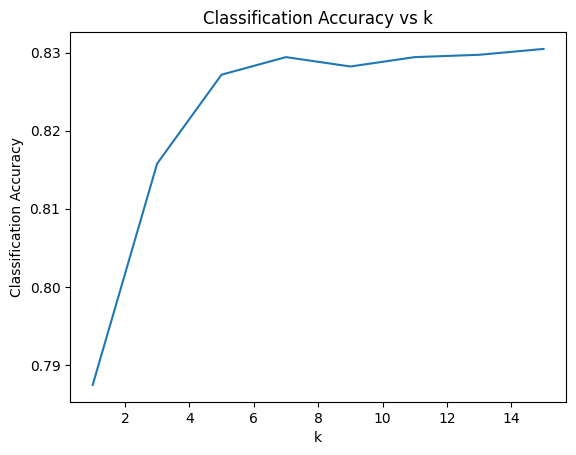

In [311]:
# Graph classification accuracy over k
plt.plot(range(1,16, 2), scores)
plt.xlabel("k")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy vs k")
plt.show()

As we can see on the graph, as k increased, the accuracy increased. This seems to be unique to the magic telescope dataset.

*For the rest of the experiments use only normalized data*

## 3. (10%) KNN regression

- Use the regression variation of your algorithm (without distance weighting) on the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.  Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff). Note this data set has an example of an inappropriate use of data which we will discuss.
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15

In [260]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff > housing_train.arff
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff > housing_test.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   144k      0 --:--:-- --:--:-- --:--:--  147k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  17873      0 --:--:-- --:--:-- --:--:-- 18154


In [364]:
# Load train housing price prediction data
housing_training_data, meta = arff.loadarff("housing_train.arff")
housing_training_data = np.array(housing_training_data.tolist())
num_features = len(housing_training_data[0]) - 1
X_train = housing_training_data[:,:num_features]
X_train = X_train.astype(np.float64)
y_train = np.expand_dims(housing_training_data[:,num_features], axis=1)
y_train = y_train.astype(np.float64)

# Load test housing price prediction data
housing_test_data, meta = arff.loadarff("housing_test.arff")
housing_test_data = np.array(housing_test_data.tolist())
num_features = len(housing_test_data[0]) - 1
X_test = housing_test_data[:,:num_features]
X_test = X_test.astype(np.float64)
y_test = np.expand_dims(housing_test_data[:,num_features], axis=1)
y_test = y_test.astype(np.float64)

X_train_norm = normalize_between_0_and_1(X_train)
X_test_norm = normalize_between_0_and_1(X_test)

In [365]:
# Train/Predict using k=1,3,...,15
mses = []
for k in range(1,16, 2):
    model = KNNClassifier(n_neighbors=k, weight_type="none")
    model.fit(X_train_norm, y_train)
    mse = model.score(X_test_norm, y_test)
    mses.append(mse)
    print(f"MSE for k={k}: {mse}")

MSE for k=1: 23.58098039215686
MSE for k=3: 14.215446623093676
MSE for k=5: 16.318258823529415
MSE for k=7: 20.028679471788713
MSE for k=9: 20.14123456790124
MSE for k=11: 21.274496840058347
MSE for k=13: 22.40819468615849
MSE for k=15: 22.584964705882356


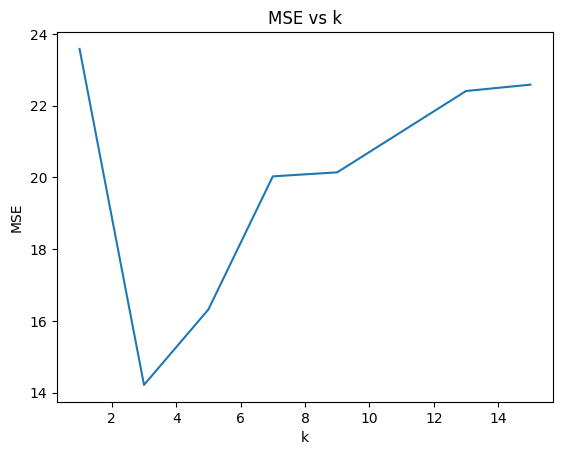

In [366]:
# Graph MSE over k
plt.plot(range(1,16, 2), mses)
plt.xlabel("k")
plt.ylabel("MSE")
plt.title("MSE vs k")
plt.show()

## 4. KNN with distance weighting
- Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.

### 4.1 (7.5%) Magic Telescope Dataset

Score for k=1: 0.7874287428742874
Score for k=3: 0.8157815781578158
Score for k=5: 0.8274827482748275
Score for k=7: 0.8291329132913291
Score for k=9: 0.8285328532853286
Score for k=11: 0.8294329432943295
Score for k=13: 0.8301830183018302
Score for k=15: 0.8304830483048304


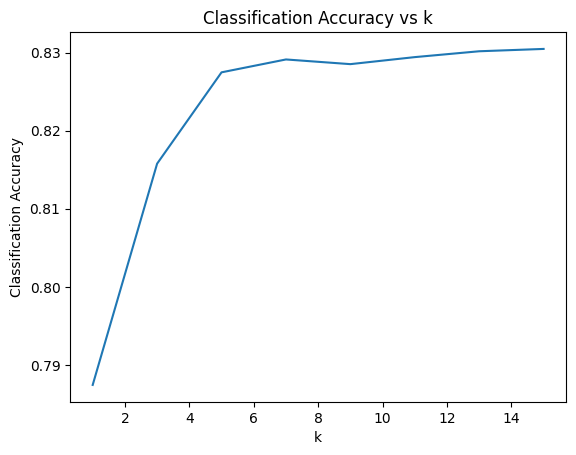

In [368]:
# Train/Predict magic telescope using distance-weighted voting
# Load train magic telescope data
magic_telescope_training_data, meta = arff.loadarff("magic_telescope_train.arff")
magic_telescope_training_data = np.array(magic_telescope_training_data.tolist())
num_features = len(magic_telescope_training_data[0]) - 1
X_train = magic_telescope_training_data[:,:num_features]
X_train = X_train.astype(np.float64)
y_train = np.expand_dims(magic_telescope_training_data[:,num_features], axis=1)
y_train = y_train.astype(str)

# Load test magic telescope data
magic_telescope_test_data, meta = arff.loadarff("magic_telescope_test.arff")
magic_telescope_test_data = np.array(magic_telescope_test_data.tolist())
num_features = len(magic_telescope_test_data[0]) - 1
X_test = magic_telescope_test_data[:,:num_features]
X_test = X_test.astype(np.float64)
y_test = np.expand_dims(magic_telescope_test_data[:,num_features], axis=1)
y_test = y_test.astype(str)

# Normalize data
X_train_norm = normalize_between_0_and_1(X_train)
X_test_norm = normalize_between_0_and_1(X_test)

model_d_weight = KNNClassifier(n_neighbors=3)
model_d_weight.fit(X_train_norm, y_train)

# Get scores
scores = []
for k in range(1,16, 2):
    model = KNNClassifier(n_neighbors=k)
    model.fit(X_train_norm, y_train)
    score = model.score(X_test_norm, y_test)
    scores.append(score)
    print(f"Score for k={k}: {score}")

# Graph classification accuracy over k
plt.plot(range(1,16, 2), scores)
plt.xlabel("k")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy vs k")
plt.show()

### 4.2 (7.5%) Housing Dataset

MSE for k=1: 23.58098039215686
MSE for k=3: 12.934556253376586
MSE for k=5: 13.141409865910855
MSE for k=7: 14.861554147794882
MSE for k=9: 15.775474649885812
MSE for k=11: 16.57348592539256
MSE for k=13: 17.44234170350149
MSE for k=15: 17.537934877248038


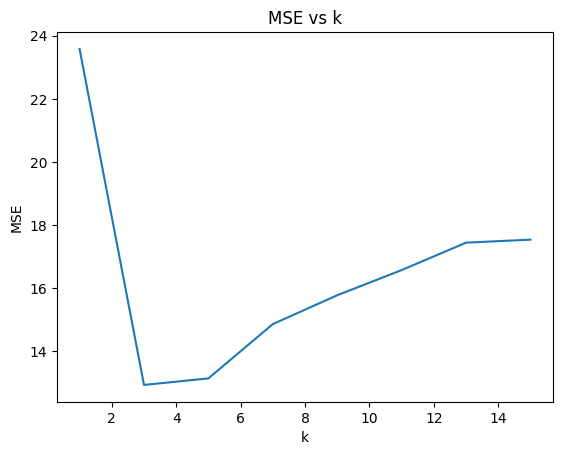

In [367]:
# Train/Predict housing using distance-weighted voting
# Load train housing price prediction data
housing_training_data, meta = arff.loadarff("housing_train.arff")
housing_training_data = np.array(housing_training_data.tolist())
num_features = len(housing_training_data[0]) - 1
X_train = housing_training_data[:,:num_features]
X_train = X_train.astype(np.float64)
y_train = np.expand_dims(housing_training_data[:,num_features], axis=1)
y_train = y_train.astype(np.float64)

# Load test housing price prediction data
housing_test_data, meta = arff.loadarff("housing_test.arff")
housing_test_data = np.array(housing_test_data.tolist())
num_features = len(housing_test_data[0]) - 1
X_test = housing_test_data[:,:num_features]
X_test = X_test.astype(np.float64)
y_test = np.expand_dims(housing_test_data[:,num_features], axis=1)
y_test = y_test.astype(np.float64)

X_train_norm = normalize_between_0_and_1(X_train)
X_test_norm = normalize_between_0_and_1(X_test)

model_d_weight = KNNClassifier(n_neighbors=3)
model_d_weight.fit(X_train_norm, y_train)

# Get mses
mses = []
for k in range(1,16, 2):
    model = KNNClassifier(n_neighbors=k)
    model.fit(X_train_norm, y_train)
    mse = model.score(X_test_norm, y_test)
    mses.append(mse)
    print(f"MSE for k={k}: {mse}")

# Graph MSE over k
plt.plot(range(1,16, 2), mses)
plt.xlabel("k")
plt.ylabel("MSE")
plt.title("MSE vs k")
plt.show()

*Discuss your results*

This time we added the inverse of distance squared as a weight for the distances. For the magic telescope dataset, it actually didn't perform any better than the model that just used a w of 1 (no inverse distance squared weight). Conversely, for the housing dataset, the models with inverse of distance squared weighting got a lower MSE than the previous models. We can see above that the lowest MSE for the housing dataset here is about 12.9, while the minimum MSE before was 14.2.

## 5. (10%) KNN with nominal and unknown data

- Use the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) task and this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.

In [369]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff > credit_approval.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34315  100 34315    0     0  74517      0 --:--:-- --:--:-- --:--:-- 75087


In [399]:
import arff
from sklearn.model_selection import train_test_split

In [437]:
# Load dataset and split into train/test sets
credit_data = arff.Arff(arff="credit_approval.arff", label_count=1)[:]
num_features = len(credit_data[0]) - 1
X = credit_data[:,:num_features]
y = np.expand_dims(credit_data[:,num_features], axis=1)
y = y.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize data
X_train_norm = normalize_between_0_and_1(X_train)
X_test_norm = normalize_between_0_and_1(X_test)

# Train/Predict credit-approval
model = KNNClassifier(n_neighbors=4)
model.fit(X_train_norm, y_train)
score = model.score(X_test_norm, y_test)
print(f"Score: {score}")

Score: 0.8309178743961353


*Explain and justify your distance metric and discuss your results*

To make the distance metric handle nominal data, I simply let it calculate the euclidian distance like normal of the normalized data. This means that if there were 5 classes, the values would be 0, 0.25, .5, 0.75, and 1. It would simply use those to calculate a euclidian distance. I figured that this would be a valid way of doing it because it seems to work quite well. I tried several n_neighbors values and found that 4 was the best with an accuracy of 83.1%. I handled unknowns by converting the nan value to be 2 in the data, which was outside of the normalized 0-1 range, making it distinct from the rest of the data classes.

## 6. (10%) Scikit-Learn KNN 
- Use the scikit-learn KNN version on magic telescope and housing and compare your results
- Try out different hyperparameters to see how well you can do. 

In [441]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import scipy.io as sio

In [453]:
# Train/Predict magic telescope using scikit's KNN
# Load train magic telescope data
magic_telescope_training_data, meta = sio.arff.loadarff("magic_telescope_train.arff")
magic_telescope_training_data = np.array(magic_telescope_training_data.tolist())
num_features = len(magic_telescope_training_data[0]) - 1
X_train = magic_telescope_training_data[:,:num_features]
X_train = X_train.astype(np.float64)
y_train = np.expand_dims(magic_telescope_training_data[:,num_features], axis=1)
y_train = y_train.astype(str)

# Load test magic telescope data
magic_telescope_test_data, meta = sio.arff.loadarff("magic_telescope_test.arff")
magic_telescope_test_data = np.array(magic_telescope_test_data.tolist())
num_features = len(magic_telescope_test_data[0]) - 1
X_test = magic_telescope_test_data[:,:num_features]
X_test = X_test.astype(np.float64)
y_test = np.expand_dims(magic_telescope_test_data[:,num_features], axis=1)
y_test = y_test.astype(str)

# Normalize data
X_train_norm = normalize_between_0_and_1(X_train)
X_test_norm = normalize_between_0_and_1(X_test)

# Train
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_norm, y_train.squeeze())
model.score(X_test_norm, y_test.squeeze())

0.8271827182718272

In [459]:
# Train/Predict housing using scikit's KNN
# Load train housing price prediction data
housing_training_data, meta = sio.arff.loadarff("housing_train.arff")
housing_training_data = np.array(housing_training_data.tolist())
num_features = len(housing_training_data[0]) - 1
X_train = housing_training_data[:,:num_features]
X_train = X_train.astype(np.float64)
y_train = np.expand_dims(housing_training_data[:,num_features], axis=1)
y_train = y_train.astype(np.float64)

# Load test housing price prediction data
housing_test_data, meta = sio.arff.loadarff("housing_test.arff")
housing_test_data = np.array(housing_test_data.tolist())
num_features = len(housing_test_data[0]) - 1
X_test = housing_test_data[:,:num_features]
X_test = X_test.astype(np.float64)
y_test = np.expand_dims(housing_test_data[:,num_features], axis=1)
y_test = y_test.astype(np.float64)

# Normalize data
X_train_norm = normalize_between_0_and_1(X_train)
X_test_norm = normalize_between_0_and_1(X_test)

# Train
model = KNeighborsRegressor(n_neighbors=2) 
model.fit(X_train_norm, y_train.squeeze())
model.score(X_test_norm, y_test.squeeze())

0.8458447338340306

*Report your comparison*

My model actually got better results than what I could get with sklearn's KNNClassifier. I got 82.72% with sklearn's model but my model got 83% at one point. This is a very small difference though. As for the sklearn regressor, it had better score than mine on the housing dataset. I managed to get 84.58% with sklearn's model.

## 7. (optional 5% extra credit): Reducing the data set
- Choose either of the data sets above and use the best k value you found.
- Implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.
- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. 
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n^2 at each step.
        - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).

In [ ]:
# Code here

Discussion. How well did it do?